In [2]:
# import packages for later use
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats


In [3]:
# load data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
# Encode categorical data
sale_price = train_data['SalePrice']
categorical_columns = train_data.dtypes[train_data.dtypes == 'object'].index.values
categoricals = train_data[categorical_columns]
categoricals['SalePrice'] = sale_price

<ipython-input-3-fc5e0a822e64>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals['SalePrice'] = sale_price


In [4]:
print("Numerical attributes: {}".format(categorical_columns))

Numerical attributes: ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


# Missing Values
We will check missing values for each categorical column

<AxesSubplot:>

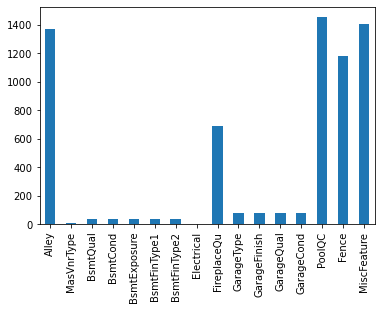

In [5]:
missing = categoricals.isnull().sum()
missing = missing[missing > 0]
missing.plot.bar()

As we can see most missing data actually corresponds to not having something. For example, "NaN" in "Alley" means the house does not have an alley. 

"Electrical" actually has one missing data, we will drop it.

<ipython-input-6-889e7b1d16c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals.dropna(subset=['Electrical'], inplace=True)
/Users/tyhe/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


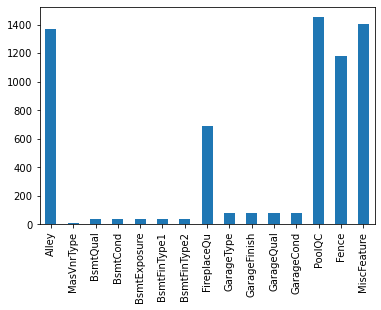

In [6]:
# Electrical does not have NA option, it is actually missing data
categoricals.dropna(subset=['Electrical'], inplace=True)
missing = categoricals.isnull().sum()
missing = missing[missing > 0]
missing.plot.bar()

# Fill Na
categoricals.fillna('None', inplace=True)

# Boxplot
We will draw simple box plots for each categorical columns against the sale price and visually check the importance of the attribute.

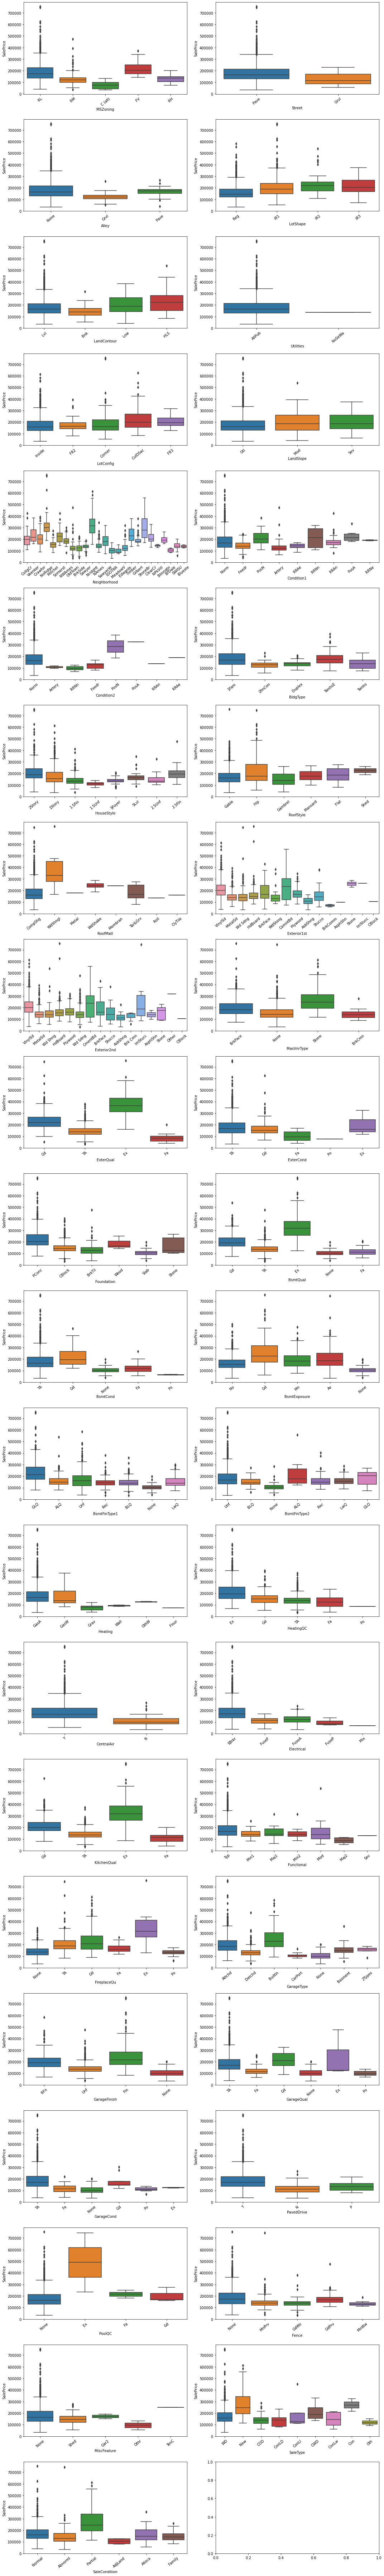

In [7]:
# Boxplot for each category
fig, axs = plt.subplots(len(categorical_columns) // 2 + 1, 2, figsize=(15, 100))
for i in range(len(categorical_columns)):
    cname = categorical_columns[i]
    ax = sns.boxplot(x=categoricals[cname], y=sale_price, ax=axs[i // 2, i % 2])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
    
plt.tight_layout()

As we can see from boxplots, some attributes(Neighbourhood, OverallQual) clearly have different means for sale price while others(MiscFeatures) may not. Later in analysis we will put more attention to one that could have higher impact on housing prices.

### Anova as Metrics
We are going to use anova test as a naive metric to measuer the importance of each of these categories and see its impact on the sale price. Anova test will test for the same mean, and a high score here corresponds to a larger chance of having different means according to different values in the categories.

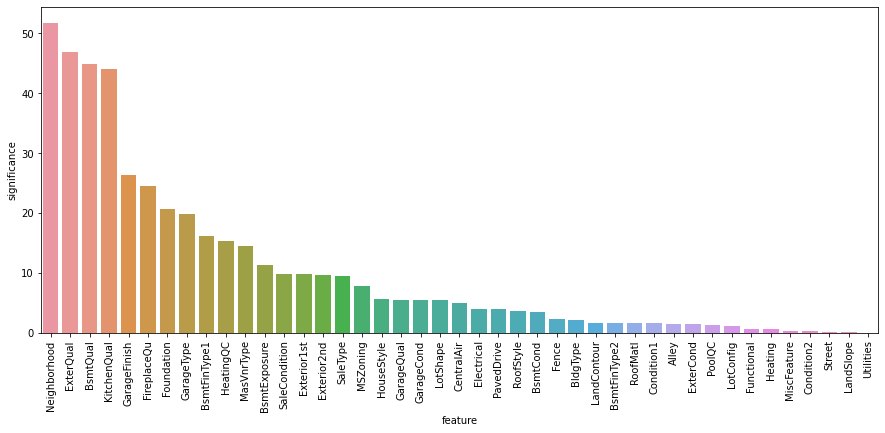

In [8]:
# Anova test 
anv = pd.DataFrame()
anv['feature'] = categorical_columns
pvals = []
y_value = categoricals['SalePrice']
for category in categorical_columns:
    column = categoricals[category]
    samples = []
    for typ in column.unique():
        col = y_value[column.values == typ].values
        samples.append(col)
    pval = stats.f_oneway(*samples)[1]
    pvals.append(pval)

anv['pval'] = pvals
anv = anv.sort_values('pval')

significance_fig, significance_ax = plt.subplots(1, figsize=(15, 6))
anv['significance'] = np.log(1./(anv['pval'] + 1e-300).values) / 10 # some metrics to measure p-values
sns.barplot(data=anv, x='feature', y='significance', ax=significance_ax)
x=plt.xticks(rotation=90)



In [14]:
# obtain the first 15 most significant columns
significant_columns = anv['feature'][:15].values
print(significant_columns)

['Neighborhood' 'ExterQual' 'BsmtQual' 'KitchenQual' 'GarageFinish'
 'FireplaceQu' 'Foundation' 'GarageType' 'BsmtFinType1' 'HeatingQC'
 'MasVnrType' 'BsmtExposure' 'SaleCondition' 'Exterior1st' 'Exterior2nd']


As we can see from the anova test that categories such as "OverallQual" and "Neighborhood" may have much more influences than columns such as "Utilities" and "LandSlope"

# Encode Categories
We will encode categorical column, changing string values to dummy numerical values.

In [7]:
def EncodeCategorical(data, column):
    encoder = LabelEncoder()
    new_column = data[column]
    # transform
    encoder.fit(new_column)
    data[column] = encoder.transform(new_column)

for category in categorical_columns:
    EncodeCategorical(categoricals, category)

In [8]:
categoricals

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,3,1,1,3,3,0,4,0,5,2,...,2,5,5,2,3,4,1,8,4,208500
1,3,1,1,3,3,0,2,0,24,1,...,2,5,5,2,3,4,1,8,4,181500
2,3,1,1,0,3,0,4,0,5,2,...,2,5,5,2,3,4,1,8,4,223500
3,3,1,1,0,3,0,0,0,6,2,...,3,5,5,2,3,4,1,8,0,140000
4,3,1,1,0,3,0,2,0,15,2,...,2,5,5,2,3,4,1,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,1,3,3,0,4,0,8,2,...,2,5,5,2,3,4,1,8,4,175000
1456,3,1,1,3,3,0,4,0,14,2,...,3,5,5,2,3,2,1,8,4,210000
1457,3,1,1,3,3,0,4,0,6,2,...,2,5,5,2,3,0,3,8,4,266500
1458,3,1,1,3,3,0,4,0,12,2,...,3,5,5,2,3,4,1,8,4,142125
